Request Access on hugging face and logint via the console first. We can not process the whole imagenet dataset so we are going to use a subsection. The code is expandable to a bigger or the whole dataset. Just replace the dataset in the respective cell.

Install requirements and make a venv or conda environment to run this notebook. This was tested and developed with a virtual environment.

Load the required packages here.

In [1]:
import matplotlib.pyplot as plt

# Stuff for loading the VAR (taken from their repo)
import os
import os.path as osp
import torch
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

# Loading the UnitMem stuff here
from torch.utils.data import Dataset
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
from collections import OrderedDict



/home/johannes/Documents/Projekte/CISPA_Application/VAR-analysis/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The proposed VAR model contains two models. One VAE to produce an encoding that the Regressor can use as tokens and upsample. Load both models here. If different model are to be analyzed, change model depth.

In [2]:
# Stuff for loading the VAR (taken from their repo)
MODEL_DEPTH = 16
assert MODEL_DEPTH in {16, 20, 24, 30}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'Models loaded')



[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422
Models loaded


Just for fun, plot some generated pictures here. Images are expected to look similar to images in the training data namely in ImageNet-1k. This code was taken from the original repo.

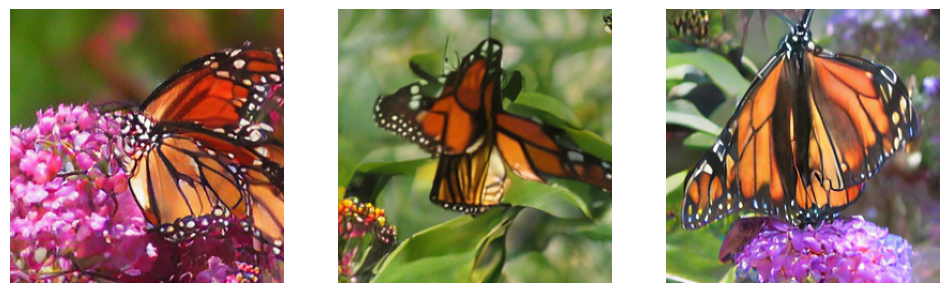

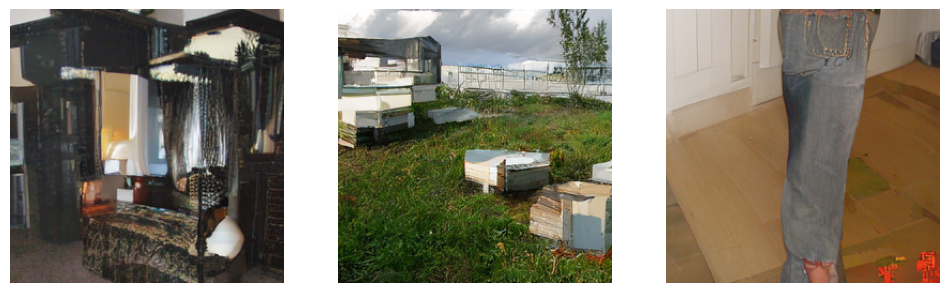

In [3]:
batch = 3
torch.manual_seed(42) # Make the images reproducible
res = var.autoregressive_infer_cfg(batch, 323, cfg=5.0).cpu() # Butterfly class with relatively high accuracy
fig, axes = plt.subplots(1, batch, figsize=(12, 4))

for i in range(batch):
    img = res[i].permute(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis("off")

plt.show()

res = var.autoregressive_infer_cfg(batch, None).cpu() # Default options
fig, axes = plt.subplots(1, batch, figsize=(12, 4))

for i in range(batch):
    img = res[i].permute(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis("off")

plt.show()



Check the architectures of both models to get a feeling what we are working with. (Skip this cell for a long boring list)

In [4]:
print(vae)
print(var)

VQVAE(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 160, eps=1e-06, affine=True)
            (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 160, eps=1e-06, affine=True)
            (dropout): Identity()
            (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nin_shortcut): Identity()
          )
        )
        (attn): ModuleList()
        (downsample): Downsample2x(
          (conv): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 160, eps=1e-06, affine=True)
            (conv1): Conv2d(160, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1,

We are creating the dataset here. The subset was uploaded to Huggingface. Please see create_datasubset.py for the creation of the dataset.

In [5]:
class ImageNetDataset(Dataset):
    """
    Custom dataset wrapper to apply transforms
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        label = item["label"]

        if self.transform:
            image = self.transform(image)

        return image, label


No we implement the forward hooks so we can access and save the activation logits after the forward pass.

In [6]:
def hook_fn(module, input, output):
    """Hook function to store activations of registered layers."""
    activations[module.__class__.__name__ + str(id(module))] = output.detach().clone()

def register_hooks(model):
    """Registers hooks for activation layers."""
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.ReLU, torch.nn.GELU, torch.nn.SiLU, torch.nn.Conv2d)): # We hook also Convolutional layers since the activations are hidden in there
            module.register_forward_hook(hook_fn)

def remove_all_forward_hooks(model: torch.nn.Module) -> None:
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks = OrderedDict()
            remove_all_forward_hooks(child)

Here we do some preprocessing. We define the augmentations similar to the paper. We finally load our custom dataset. The dataset can be changed to a bigger dataset for a more statistical invariant analysis. On limited hardware a smaller set is advisable.

In [7]:
# Image Transformations
s = 1
color_jitter = transforms.ColorJitter(0.9 * s, 0.9 * s, 0.9 * s, 0.1 * s)
flip = transforms.RandomHorizontalFlip()
Aug = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # This does not change width an height
    transforms.RandomApply([flip], p=0.5),
    transforms.RandomApply([color_jitter], p=0.9),
    transforms.RandomGrayscale(p=0.1)
])

data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Load dataset (ImageNet reduced)
# dataset = load_dataset("j-reber/imagenet_reduced_trainingset", split="train")
# dataset = load_dataset("j-reber/imagenet_reduced_trainingset-five_samples", split="train")
dataset = load_dataset("j-reber/imagenet_reduced_trainingset-single_sample", split="train")
imagenet_dataset = ImageNetDataset(dataset, transform=data_transforms)

# sublist = list(range(0, 2, 1)) # TODO Remove for full dataset
# subset = torch.utils.data.Subset(imagenet_dataset, sublist)
# dataloader = torch.utils.data.DataLoader(subset, 1, shuffle=False, num_workers=2) # TODO change here for full dataset
dataloader = torch.utils.data.DataLoader(imagenet_dataset, batch_size=1, shuffle=False, num_workers=2)


Now check the per Unit Memorization. For that we hook the outputs of the activation functions and make a couple of forward passes for the vae models. We apply the formula from the paper.

In [8]:
unit_mem_per_layer_vae = [[] for _ in range(1000)]
class_mem_per_layer_vae = [[] for _ in range(1000)]
activations = {}

# Register hooks
register_hooks(vae)

# Model setup
vae.to(device)
var.to(device)
vae.train()
var.train()

unit_mem_per_layer = []
class_mem_per_layer = []

for img, label in iter(dataloader):
    img, label = img.to(device), label.to(device)
    print("Processing label:", label.item())
    accumulated_activations = {}
    raw_activations = {}
    var_activations = {}

    for j in range(10): # Calculate Unit Mem according to SprintML repo/paper
        # print("Iteration:", j)
        with torch.no_grad():
            encoding_indices = vae.encoder(Aug(img))
            decoded = vae.decoder(encoding_indices)
            encoding = encoding_indices.view(1, 32, -1)  # Shape: [1, 32, 4]
            encoding = encoding.permute(0, 2, 1)  # Shape: [1, 4, 32]

        # Accumulate activations
        for layer_name, activation in activations.items():
            if layer_name not in accumulated_activations:
                accumulated_activations[layer_name] = torch.zeros_like(activation)
            accumulated_activations[layer_name] += activation

    # Compute averaged activations
    averaged_activations = {layer: accumulated_activations[layer] / 10 for layer in accumulated_activations}
    # print(len(averaged_activations))


    # Process activations
    unit_selectivity = []
    final = []
    for _, out in averaged_activations.items():
        # print(out.shape)
        batch_size, channels, height, width = out.shape  # Extract dimensions dynamically
        reshaped_out = out.view(channels, -1)
        my = np.mean(reshaped_out.cpu().numpy(), axis=1)
        final.append(my)

        if len(final) > 1:
            min_length = min(len(arr) for arr in final)  # Ensure uniform size
            final_trimmed = [arr[:min_length] for arr in final]
            out1 = np.mean(np.array(final_trimmed), axis=0)
            # Compute selectivity
            maxout = np.max(out1, axis=0)
            medianout = np.median(np.sort(out1, axis=0)[:-1], axis=0)
            selectivity = (maxout - medianout) / (maxout + medianout)
                # print("Selectivity:", selectivity)  # Print for debugging
            unit_selectivity.append(selectivity)  # Append selectivity
                # print(final1)
    unit_mem_per_layer_vae[label.item()].append(unit_selectivity)

    # print(len(unit_selectivity))

    # Class Mem
    with torch.no_grad():
        encoding_indices = vae.encoder(img)
        decoded = vae.decoder(encoding_indices)

        # Accumulate activations
    for layer_name, activation in activations.items():
        if layer_name not in raw_activations:
                raw_activations[layer_name] = torch.zeros_like(activation)
        raw_activations[layer_name] += activation

    final = []
    class_selectivity = []
    for _, out in raw_activations.items():
        # print(out.shape)
        batch_size, channels, height, width = out.shape  # Extract dimensions dynamically
        reshaped_out = out.view(channels, -1)
        my = np.mean(reshaped_out.cpu().numpy(), axis=1)
        final.append(my)
        if len(final) > 1:
            min_length = min(len(arr) for arr in final)  # Ensure uniform size
            final_trimmed = [arr[:min_length] for arr in final]
            out1 = np.mean(np.array(final_trimmed), axis=0)

            # Compute selectivity
            maxout = np.max(out1, axis=0)
            medianout = np.median(np.sort(out1, axis=0)[:-1], axis=0)
            selectivity = (maxout - medianout) / (maxout + medianout)

            # print("Selectivity:", selectivity)  # Print for debugging
            class_selectivity.append(selectivity)  # Append selectivity
    class_mem_per_layer_vae[label.item()].append(class_selectivity)
remove_all_forward_hooks(vae)


Processing label: 726
Processing label: 917
Processing label: 13
Processing label: 939
Processing label: 6
Processing label: 983
Processing label: 655
Processing label: 579
Processing label: 702
Processing label: 845
Processing label: 69
Processing label: 822
Processing label: 575
Processing label: 906
Processing label: 752
Processing label: 219
Processing label: 192
Processing label: 191
Processing label: 292
Processing label: 848
Processing label: 108
Processing label: 372
Processing label: 765
Processing label: 473
Processing label: 525
Processing label: 639
Processing label: 686
Processing label: 99
Processing label: 127
Processing label: 76
Processing label: 905
Processing label: 550
Processing label: 30
Processing label: 634
Processing label: 907
Processing label: 979
Processing label: 718
Processing label: 154
Processing label: 914
Processing label: 293
Processing label: 9
Processing label: 922
Processing label: 130
Processing label: 33
Processing label: 968
Processing label: 71

In [9]:
unit_mem_per_layer_var = [[] for _ in range(1000)]
class_mem_per_layer_var = [[] for _ in range(1000)]

activations = {}
register_hooks(var)

vae.to(device)
var.to(device)
vae.train()
var.train()

for img, label in iter(dataloader):
    img, label = img.to(device), label.to(device)
    print("Processing label:", label.item())
    final = []
    accumulated_activations = {}
    raw_activations = {}
    var_activations = {}

    for j in range(10): # Calculate Unit Mem according to SprintML repo/paper
        with torch.no_grad():
            gt_idx_Bl = vae.img_to_idxBl(Aug(img))
            x_BLCv_wo_first_l = vae.quantize.idxBl_to_var_input(gt_idx_Bl)
            logits_BLV = var(label, x_BLCv_wo_first_l)
        # Accumulate activations
        for layer_name, activation in activations.items():
            if layer_name not in accumulated_activations:
                accumulated_activations[layer_name] = torch.zeros_like(activation)
            accumulated_activations[layer_name] += activation

    # Compute averaged activations
    averaged_activations = {layer: accumulated_activations[layer] / 10 for layer in accumulated_activations}

    # Process activations
    unit_selectivity = []
    for _, out in averaged_activations.items():
        if out.dim() == 2:
            out = out.unsqueeze(1)

        my = np.mean(out.cpu().numpy(), axis=1)
        out1 = np.mean(my, axis=0)
        maxout = np.max(out1, axis=0)
        medianout = np.median(np.sort(out1, axis=0)[:-1], axis=0)
        selectivity = (maxout - medianout) / (maxout + medianout)
        unit_selectivity.append(selectivity)  # Append selectivity
    unit_mem_per_layer_var[label.item()].append(unit_selectivity)


    # Class Mem
    with torch.no_grad():
        gt_idx_Bl = vae.img_to_idxBl(img)
        x_BLCv_wo_first_l = vae.quantize.idxBl_to_var_input(gt_idx_Bl)
        logits_BLV = var(label, x_BLCv_wo_first_l)

        # Accumulate activations
    for layer_name, activation in activations.items():
        if layer_name not in raw_activations:
                raw_activations[layer_name] = torch.zeros_like(activation)
        raw_activations[layer_name] += activation

    final = []
    class_selectivity = []
    for _, out in raw_activations.items():
        if out.dim() == 2:
            out = out.unsqueeze(1)
        my = np.mean(out.cpu().numpy(), axis=1)
        out1 = np.mean(np.array(my), axis=0)
        # Compute selectivity
        maxout = np.max(out1, axis=0)
        medianout = np.median(np.sort(out1, axis=0)[:-1], axis=0)
        selectivity = (maxout - medianout) / (maxout + medianout)

        class_selectivity.append(selectivity)  # Append selectivity
    class_mem_per_layer_var[label.item()].append(class_selectivity)


remove_all_forward_hooks(var)

Processing label: 726


/home/johannes/Documents/Projekte/CISPA_Application/VAR-analysis/models/var.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Processing label: 917
Processing label: 13
Processing label: 939
Processing label: 6
Processing label: 983
Processing label: 655
Processing label: 579
Processing label: 702
Processing label: 845
Processing label: 69
Processing label: 822
Processing label: 575
Processing label: 906
Processing label: 752
Processing label: 219
Processing label: 192
Processing label: 191
Processing label: 292
Processing label: 848
Processing label: 108
Processing label: 372
Processing label: 765
Processing label: 473
Processing label: 525
Processing label: 639
Processing label: 686
Processing label: 99
Processing label: 127
Processing label: 76
Processing label: 905
Processing label: 550
Processing label: 30
Processing label: 634
Processing label: 907
Processing label: 979
Processing label: 718
Processing label: 154
Processing label: 914
Processing label: 293
Processing label: 9
Processing label: 922
Processing label: 130
Processing label: 33
Processing label: 968
Processing label: 719
Processing label: 65

We now define a method to analyze the results. It checks the number of samples per class and then gives the most occuring layers. It also takes the highest ten percent of activations and assigns them regarding to layer and class.

In [40]:
def analyze_results(result_list, model_name):
    """
    This method analyzes the produced results.
    """
    results = np.array(result_list)  # Shape (b, c, a)
    results = results.reshape(1, results.shape[0], results.shape[2])

    collapsed_b = np.mean(results, axis=0)

    argmax_a = np.argmax(collapsed_b, axis=1)  # Shape (c,)
    most_frequent = np.bincount(argmax_a).argmax()
    print("Most frequent layer value along a:", most_frequent)
    unique, counts = np.unique(argmax_a, return_counts=True)
    sorted_indices = np.argsort(-counts)
    filtered_unique = unique[sorted_indices]
    filtered_counts = counts[sorted_indices]

    # Limit the number of buckets to at most 30
    max_buckets = 30
    if len(filtered_unique) > max_buckets:
        filtered_unique = filtered_unique[:max_buckets]
        filtered_counts = filtered_counts[:max_buckets]

    # First plot: bar plot for most memorizing activations
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(filtered_unique)), filtered_counts, tick_label=filtered_unique, edgecolor='black', alpha=0.7)
    # plt.bar(filtered_unique, filtered_counts, edgecolor='black', alpha=0.7)
    plt.xlabel("Activation", fontsize=16, fontweight='bold')
    plt.ylabel("Frequency", fontsize=16, fontweight='bold')
    # plt.xticks(filtered_unique, fontsize=12, fontweight='bold', rotation=90)
    plt.xticks(range(len(filtered_unique)), filtered_unique, fontsize=12, fontweight='bold', rotation=90)
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"output/most_memorizing_activations_{model_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Second plot: line plot for variance of activations
    print("Maximum Memorization: ", np.max(collapsed_b))
    print("The Max memorization belongs to [class, layer]:", np.unravel_index(np.argmax(collapsed_b), collapsed_b.shape))
    variance_per_layer = np.var(collapsed_b, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(range(results.shape[-1]), variance_per_layer, color='tab:blue')
    plt.xlabel("Activation", fontsize=16, fontweight='bold')
    plt.ylabel("Variance", fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold', rotation=60)
    plt.yticks(fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"output/most_varying_activations_{model_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate general variance
    collapsed_a = np.mean(collapsed_b, axis=1)  # Shape (c,)
    averaged_variance = np.var(collapsed_a)  # Single value
    print("Averaged variance:", averaged_variance)


Most frequent layer value along a: 41


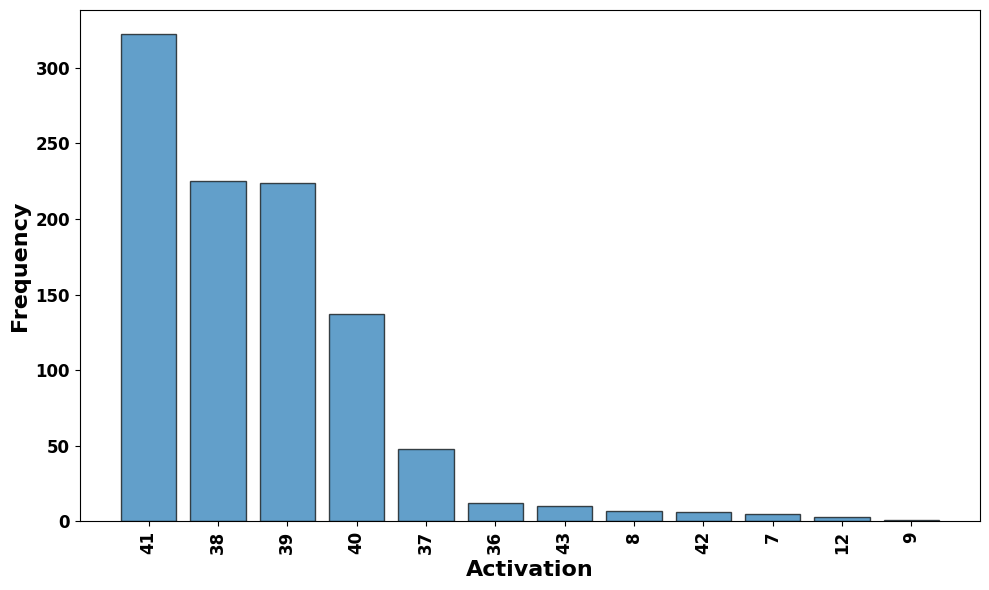

Maximum Memorization:  115830.77
The Max memorization belongs to [class, layer]: (np.int64(447), np.int64(39))


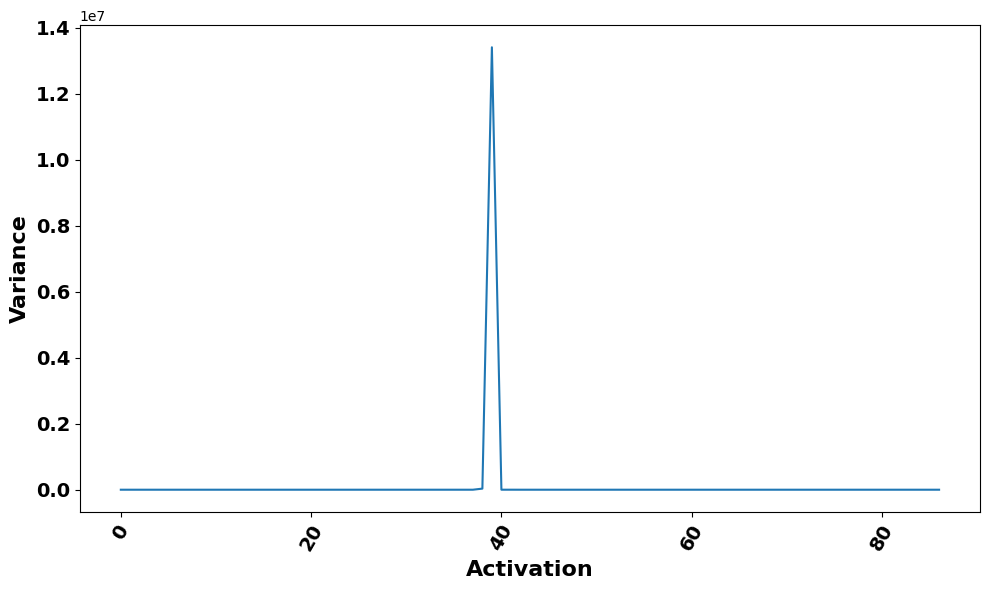

Averaged variance: 1776.9467


In [41]:
analyze_results(unit_mem_per_layer_vae, model_name="unit_mem_per_layer_vae_aug")

Most frequent layer value along a: 38
(16,) (16,)


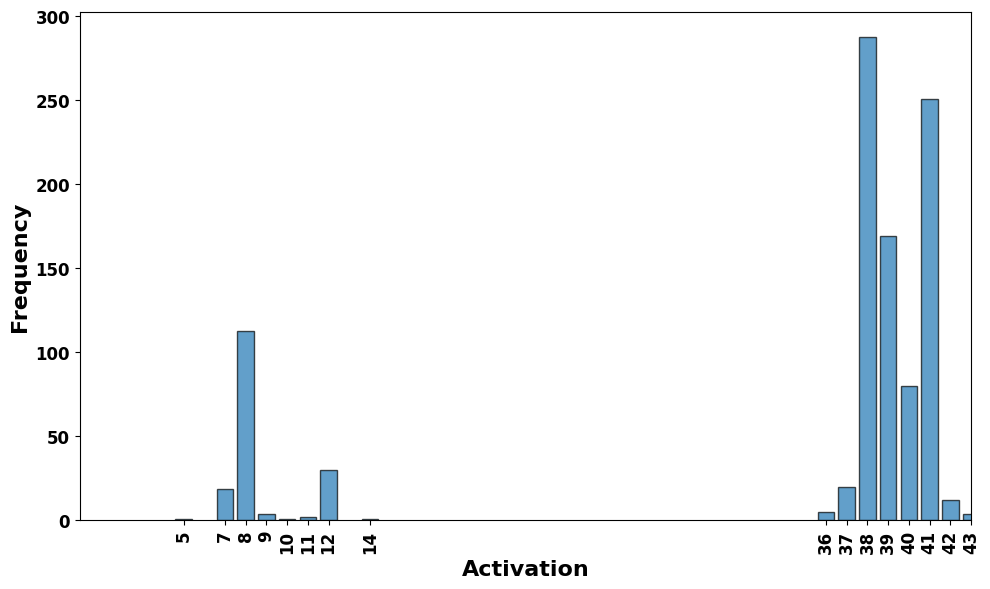

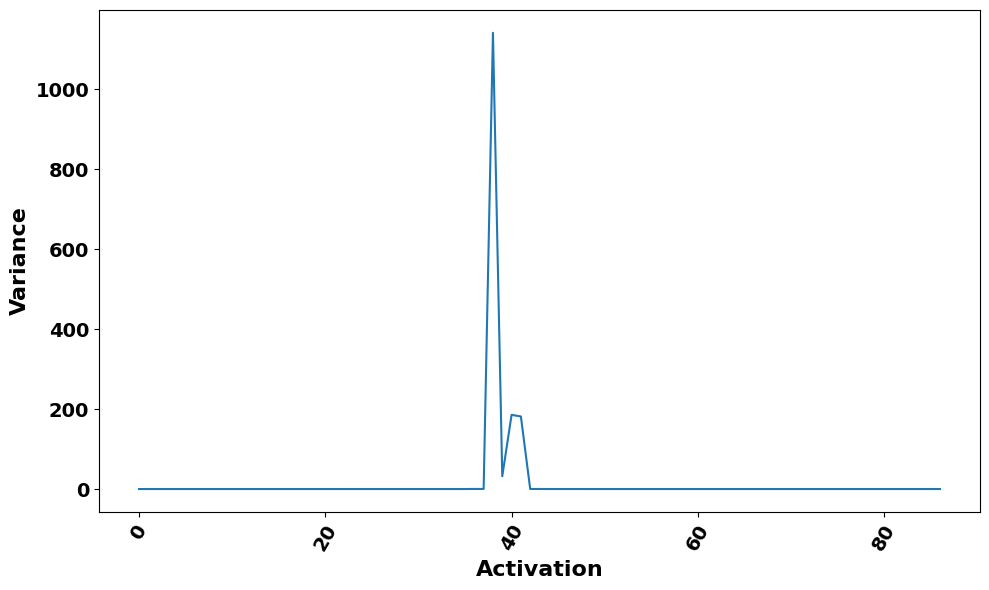

Averaged variance: 0.19545248


In [18]:
analyze_results(class_mem_per_layer_vae, model_name="class_mem_per_layer_vae")


Most frequent layer value along a: 17


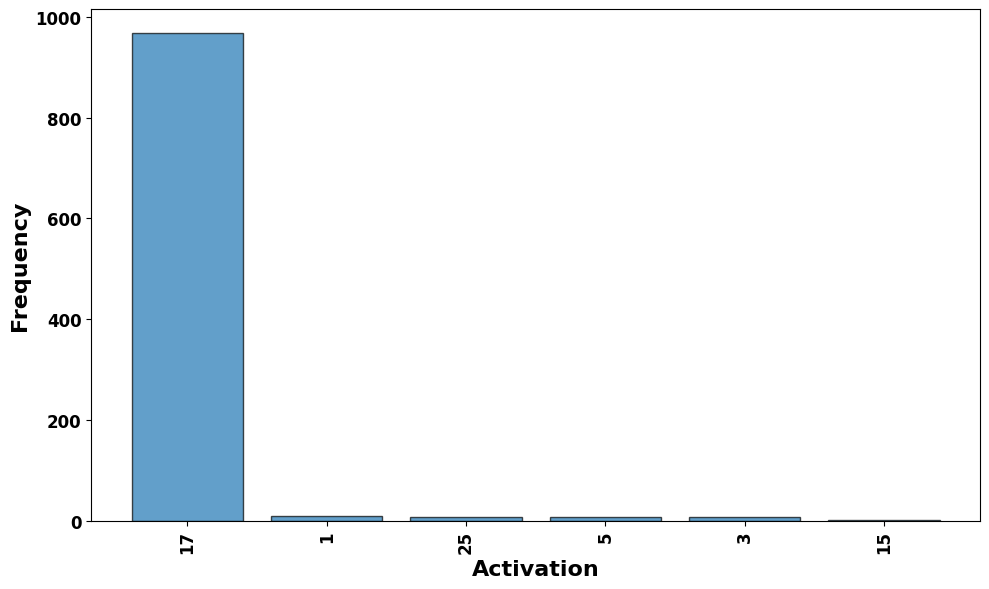

Maximum Memorization:  1.343899
The Max memorization belongs to [class, layer]: (np.int64(858), np.int64(5))


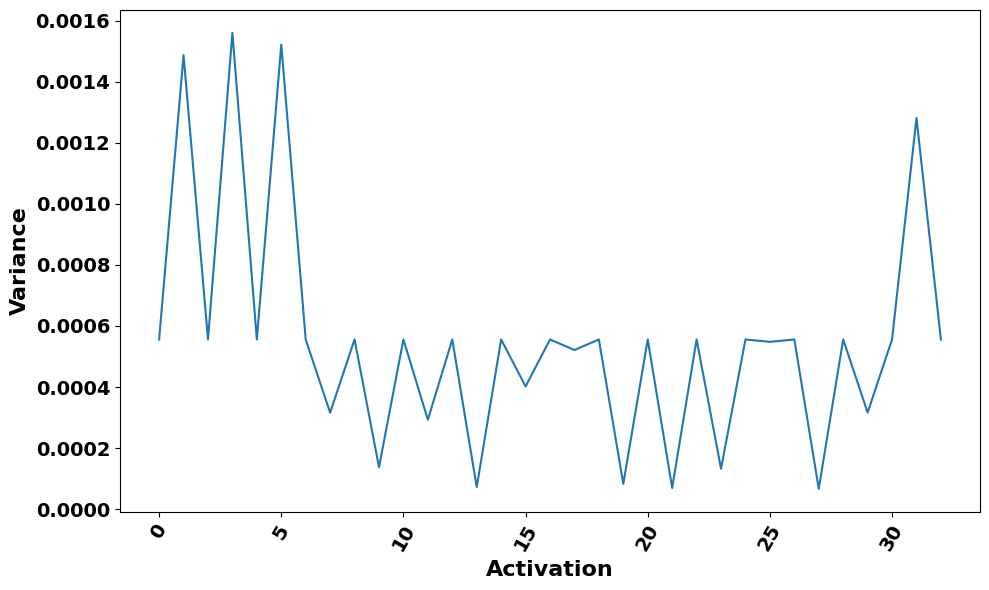

Averaged variance: 0.00017114083


In [42]:
analyze_results(unit_mem_per_layer_var, model_name="unit_mem_per_layer_var_aug")


Most frequent layer value along a: 17


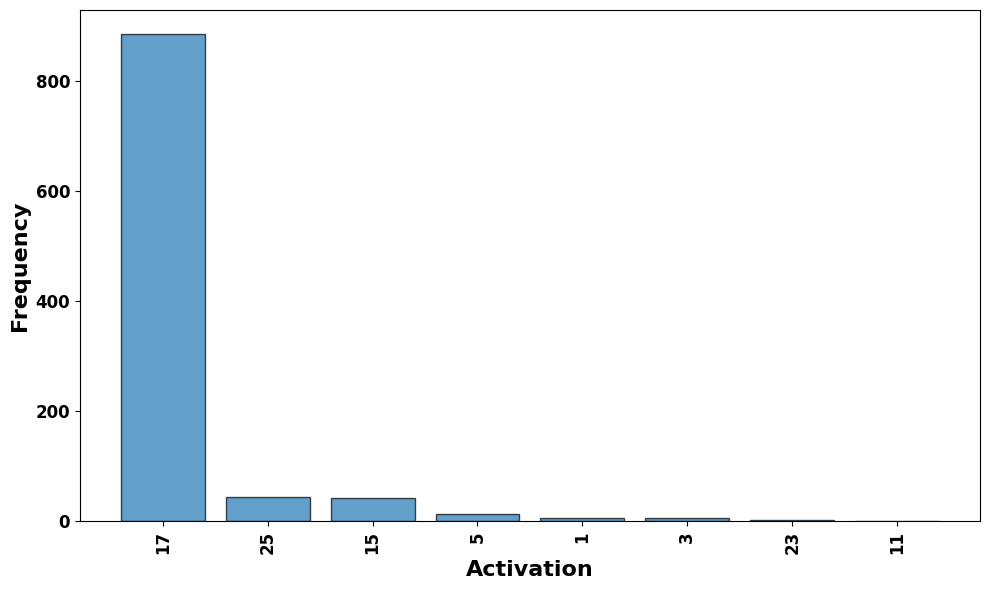

Maximum Memorization:  1.381207
The Max memorization belongs to [class, layer]: (np.int64(409), np.int64(17))


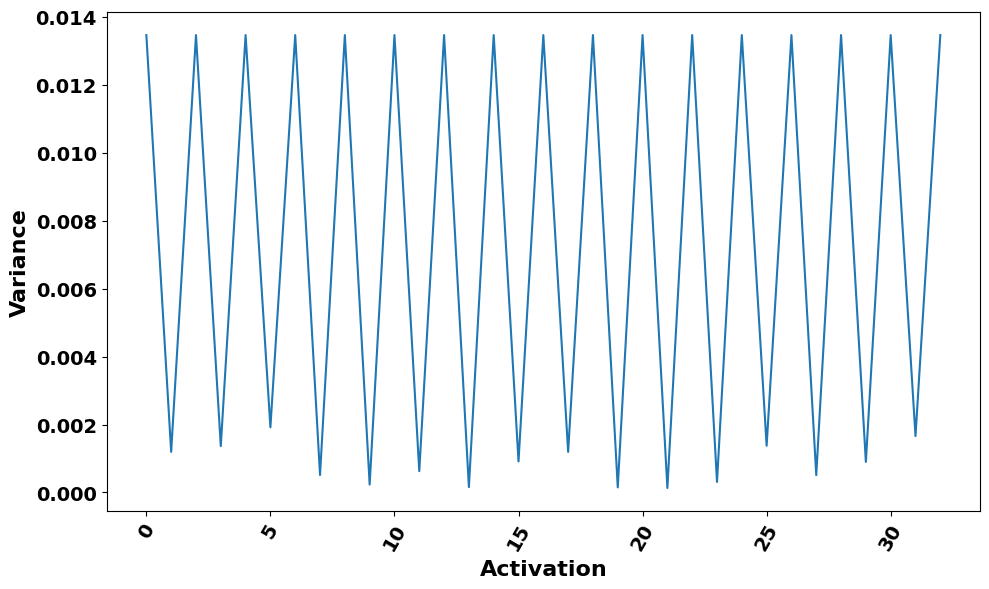

Averaged variance: 0.0035880967


In [43]:
analyze_results(class_mem_per_layer_var, model_name="class_mem_per_layer_var")